In [1]:
!pip install shap lightgbm seaborn lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
shap.initjs()

In [5]:
titanic = sns.load_dataset('titanic')
titanic.head()

survived  pclass     sex   age  ...  deck  embark_town  alive  alone
0         0       3    male  22.0  ...   NaN  Southampton     no  False
1         1       1  female  38.0  ...     C    Cherbourg    yes  False
2         1       3  female  26.0  ...   NaN  Southampton    yes   True
3         1       1  female  35.0  ...     C  Southampton    yes  False
4         0       3    male  35.0  ...   NaN  Southampton     no   True

[5 rows x 15 columns]

In [7]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

df = titanic[features + [target]].copy()

df['age'].fillna(df['age'].median(), inplace=True)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

df = pd.get_dummies(df, columns=['sex', 'embarked'], drop_first=True)

X = df.drop(target, axis=1)
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

pclass   age  sibsp  parch     fare  sex_male  embarked_Q  embarked_S
331       1  45.5      0      0  28.5000      True       False        True
733       2  23.0      0      0  13.0000      True       False        True
382       3  32.0      0      0   7.9250      True       False        True
704       3  26.0      1      0   7.8542      True       False        True
813       3   6.0      4      2  31.2750     False       False        True

In [11]:
import lightgbm as lgb
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(random_state=42)

In [12]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [13]:
print(f"Acurácia do modelo no conjunto de teste: {accuracy:.2f}")

Acurácia do modelo no conjunto de teste: 0.83


In [15]:
import lime
import lime.lime_tabular

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Não Sobreviveu', 'Sobreviveu'],
    mode='classification'
)

In [18]:
predictions = model.predict_proba(X_test)
df_results = X_test.copy()
df_results['prob_sobreviver'] = predictions[:, 1]
df_results['predicao_final'] = y_pred
df_results['real'] = y_test

In [25]:
display(X_test.loc[sobrevivente])

pclass            2
age             6.0
sibsp             0
parch             1
fare           33.0
sex_male      False
embarked_Q    False
embarked_S     True
Name: 720, dtype: object

In [22]:
sobrevivente = df_results[df_results['predicao_final'] == 1].index[0]

exp_lime = explainer_lime.explain_instance(
    data_row=X_test.loc[sobrevivente].values,
    predict_fn=model.predict_proba,
    num_features=5
)

exp_lime.show_in_notebook(show_table=True)

In [27]:
nao_sobrevivente = df_results[df_results['predicao_final'] == 0].index[1]
display(X_test.loc[nao_sobrevivente])

pclass            2
age            31.0
sibsp             0
parch             0
fare           10.5
sex_male       True
embarked_Q    False
embarked_S     True
Name: 439, dtype: object

In [28]:
exp_lime_2 = explainer_lime.explain_instance(
    data_row=X_test.loc[nao_sobrevivente].values,
    predict_fn=model.predict_proba,
    num_features=5
)

exp_lime_2.show_in_notebook(show_table=True)

In [29]:
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)

In [37]:
if isinstance(shap_values, list):
    shap.force_plot(
        explainer_shap.expected_value[1],
        shap_values[1][X_test.index.get_loc(sobrevivente), :],
        X_test.loc[sobrevivente],
    )
else:
    shap.force_plot(
        explainer_shap.expected_value,
        shap_values[X_test.index.get_loc(sobrevivente), :],
        X_test.loc[sobrevivente]
    )

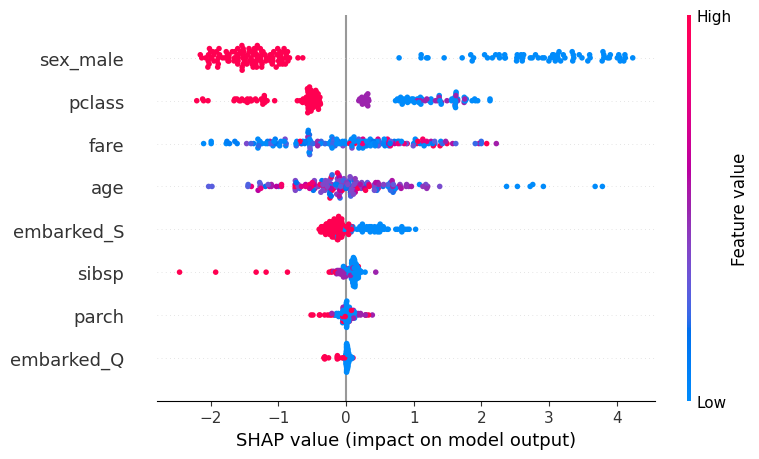

In [40]:
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test)
else:
    if len(shap_values.shape) == 1:
        shap_values = shap_values.reshape(1, -1)
    shap.summary_plot(shap_values, X_test)

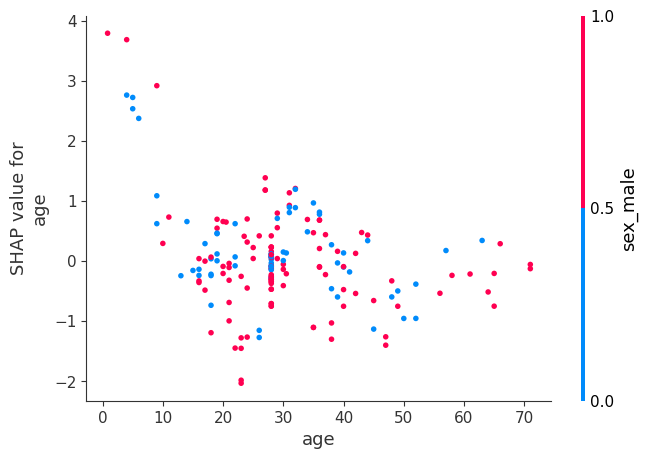

In [41]:
if isinstance(shap_values, list):
  sv = shap_values[1]
else:
  sv = getattr(shap_values, 'values', shap_values)
  if len(sv.shape) == 1:
    sv = sv.reshape(1, -1)

shap.dependence_plot('age', sv, X_test, interaction_index='sex_male')

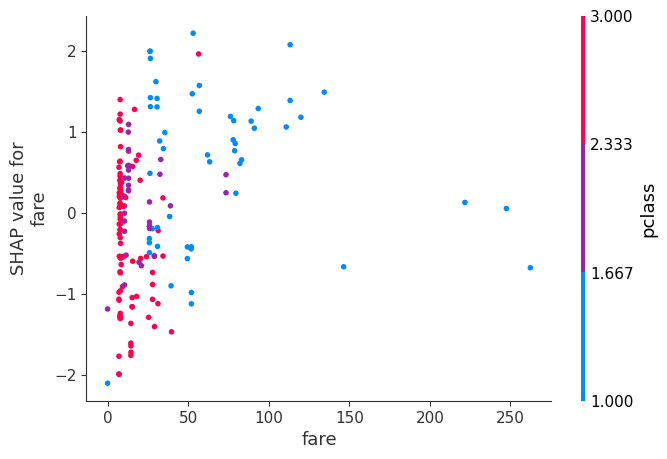

In [42]:
shap.dependence_plot('fare', sv, X_test, interaction_index='pclass')

In [43]:
import matplotlib.pyplot as plt

df_bias = df.copy()
df_bias['pred'] = model.predict(X)
df_bias['sexo'] = np.where(df_bias['sex_male'] == 1, 'Masculino', 'Feminino')

resumo_vies = (
    df_bias.groupby('sexo')[['survived', 'pred']]
    .mean()
    .rename(columns={
        'survived': 'Taxa Real de Sobrevivência',
        'pred': 'Taxa Prevista pelo Modelo'
    })
)

display(resumo_vies)

Taxa Real de Sobrevivência  Taxa Prevista pelo Modelo
sexo                                                            
Feminino                     0.742038                   0.786624
Masculino                    0.188908                   0.129983

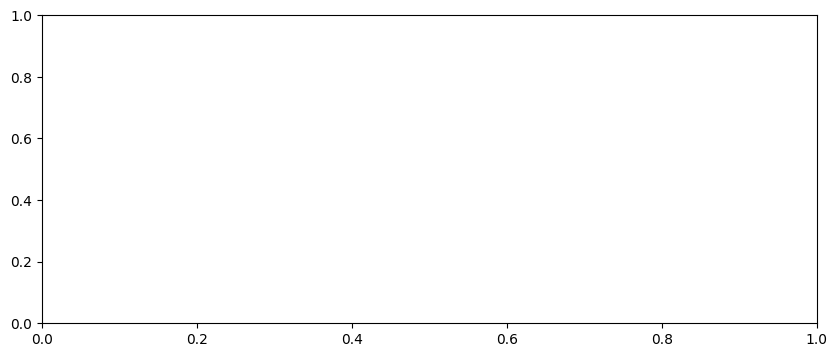

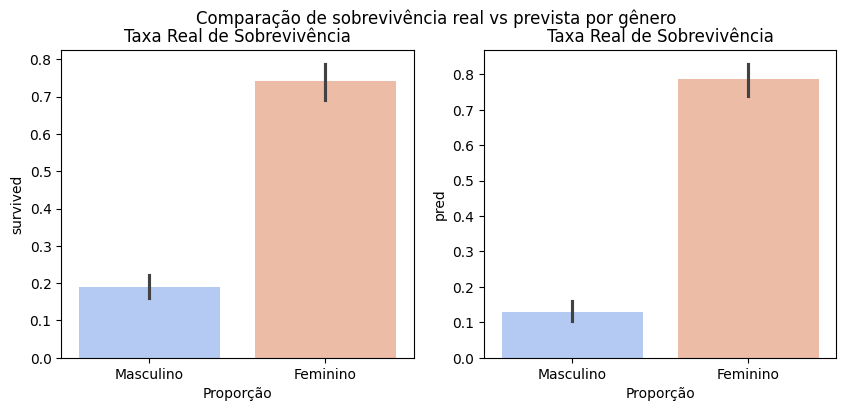

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=df_bias, x='sexo', y='survived', ax=ax[0], palette='coolwarm')
ax[0].set_title('Taxa Real de Sobrevivência')
ax[0].set_xlabel('Proporção')

sns.barplot(data=df_bias, x='sexo', y='pred', ax=ax[1], palette='coolwarm')
ax[1].set_title('Taxa Real de Sobrevivência')
ax[1].set_xlabel('Proporção')

plt.suptitle('Comparação de sobrevivência real vs prevista por gênero')
plt.show()